In [3]:
import sys
!{sys.executable} -m pip install -r requirements.txt

  Using cached pandas-2.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (91 kB)
  Using cached numpy-2.3.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached matplotlib-3.10.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached scipy-1.16.0-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (61 kB)
  Using cached statsmodels-0.14.5-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_28_x86_64.whl.metadata (9.5 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.0-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_

# Skyline Protein Quantitation Analysis

This notebook provides a clean, simple workflow for analyzing Skyline protein quantitation data:

1. **Load Data**: Read quantitation and metadata files
2. **Parse Proteins**: Extract UniProt identifiers from protein column
3. **Clean Sample Names**: Remove common prefix/suffix from sample names
4. **Match Metadata**: Link samples to experimental metadata
5. **Analyze Data Completeness**: Visualize missing data patterns
6. **Summarize**: Provide sample and protein summaries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

# Set up plotting style
plt.style.use('default')

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [7]:
# Load the data files
print("=== LOADING DATA ===\n")

# Read files
protein_data = pd.read_csv('2025-6-CSF-EV-Pilot-ProteinQuant.csv')
metadata = pd.read_csv('2025-6-CSF-EV-Pilot-MetaData.csv')

print(f"Protein data shape: {protein_data.shape}")
print(f"Metadata shape: {metadata.shape}")

print(f"\nProtein data columns: {list(protein_data.columns[:5])}{'...' if len(protein_data.columns) > 5 else ''}")
print(f"Metadata columns: {list(metadata.columns)}")

# Show sample of each
print("\n=== METADATA SAMPLE ===")
print(metadata.head())

print("\n=== PROTEIN DATA SAMPLE ===")
print(protein_data.iloc[:3, :5])

=== LOADING DATA ===

Protein data shape: (3378, 51)
Metadata shape: (48, 5)

Protein data columns: ['Protein', 'Protein Description', 'Protein Gene', 'A01-511-84A-C4-001 Sum Normalized Area', 'A02-Hoof17-002 Sum Normalized Area']...
Metadata columns: ['Replicate', 'Sample Type', 'Analyte Concentration', 'Subject', 'Timepoint']

=== METADATA SAMPLE ===
            Replicate      Sample Type  Analyte Concentration Subject  \
0  A01-511-84A-C4-001          Unknown                    NaN      84   
1      A02-Hoof17-002  Quality Control                    NaN  Hoof17   
2  A03-304-75B-B4-003          Unknown                    NaN      75   
3  A04-450-08A-C7-004          Unknown                    NaN      08   
4  A05-051-21B-D6-005          Unknown                    NaN      21   

  Timepoint  
0       D02  
1       NaN  
2       D13  
3       D02  
4       D13  

=== PROTEIN DATA SAMPLE ===
                 Protein                                Protein Description  \
0  sp|O43240|K

In [8]:
def parse_uniprot_identifier(protein_id):
    """
    Simple function to extract UniProt accession from protein identifier.
    Handles formats like: sp|P12345|PROT_HUMAN -> P12345
    """
    if pd.isna(protein_id):
        return {'accession': '', 'database': '', 'entry_name': ''}
    
    protein_id = str(protein_id).strip()
    
    # Pattern: sp|P12345|PROT_HUMAN or tr|Q9ABC1|Q9ABC1_MOUSE
    match = re.match(r'^(sp|tr)\|([A-Z0-9]+)\|([A-Z0-9_]+)$', protein_id)
    if match:
        db = 'SwissProt' if match.group(1) == 'sp' else 'TrEMBL'
        return {
            'accession': match.group(2),
            'database': db,
            'entry_name': match.group(3)
        }
    
    # If no match, try to find accession pattern
    acc_match = re.search(r'([A-Z][A-Z0-9]{5,9})', protein_id)
    if acc_match:
        return {
            'accession': acc_match.group(1),
            'database': '',
            'entry_name': ''
        }
    
    return {'accession': '', 'database': '', 'entry_name': ''}

# Parse UniProt identifiers
print("=== PARSING PROTEIN IDENTIFIERS ===\n")

# Apply parsing to protein column
parsed_proteins = protein_data['Protein'].apply(parse_uniprot_identifier)
protein_info = pd.DataFrame(parsed_proteins.tolist())

# Add parsed columns to protein data
protein_data['UniProt_Accession'] = protein_info['accession']
protein_data['UniProt_Database'] = protein_info['database']
protein_data['UniProt_Entry_Name'] = protein_info['entry_name']

# Show parsing results
total_proteins = len(protein_data)
has_accession = (protein_data['UniProt_Accession'] != '').sum()
has_database = (protein_data['UniProt_Database'] != '').sum()

print(f"Total proteins: {total_proteins}")
print(f"Accessions extracted: {has_accession} ({has_accession/total_proteins*100:.1f}%)")
print(f"Database identified: {has_database} ({has_database/total_proteins*100:.1f}%)")

if has_database > 0:
    db_counts = protein_data['UniProt_Database'].value_counts()
    print(f"Database distribution: {dict(db_counts)}")

# Show examples
print("\n=== PARSING EXAMPLES ===")
examples = protein_data[['Protein', 'UniProt_Database', 'UniProt_Accession', 'UniProt_Entry_Name']].head(5)
print(examples.to_string(index=False))

=== PARSING PROTEIN IDENTIFIERS ===

Total proteins: 3378
Accessions extracted: 3375 (99.9%)
Database identified: 3293 (97.5%)
Database distribution: {'SwissProt': np.int64(3283), '': np.int64(85), 'TrEMBL': np.int64(10)}

=== PARSING EXAMPLES ===
              Protein UniProt_Database UniProt_Accession UniProt_Entry_Name
sp|O43240|KLK10_HUMAN        SwissProt            O43240        KLK10_HUMAN
 sp|O76031|CLPX_HUMAN        SwissProt            O76031         CLPX_HUMAN
 sp|P02787|TRFE_HUMAN        SwissProt            P02787         TRFE_HUMAN
 sp|P06858|LIPL_HUMAN        SwissProt            P06858         LIPL_HUMAN
sp|P14415|AT1B2_HUMAN        SwissProt            P14415        AT1B2_HUMAN


In [9]:
# Parse gene names and descriptions - prioritize existing Gene column
print("=== PARSING GENE NAMES AND DESCRIPTIONS ===\n")

def parse_gene_from_description(protein_description):
    """
    Extract gene name from protein description text using GN= pattern.
    """
    if pd.isna(protein_description):
        return ''
    
    desc_str = str(protein_description).strip()
    
    # Extract gene name from GN= pattern
    gene_match = re.search(r'GN=([^=\s]+)', desc_str)
    return gene_match.group(1).strip() if gene_match else ''

def clean_description(protein_description):
    """
    Clean description by removing UniProt annotation fields.
    """
    if pd.isna(protein_description):
        return ''
    
    desc_str = str(protein_description).strip()
    
    # Remove patterns like OS=..., OX=..., GN=..., PE=..., SV=...
    clean_desc = re.sub(r'\s+(?:OS|OX|GN|PE|SV)=[^=]*(?=\s+(?:OS|OX|GN|PE|SV)=|$)', '', desc_str)
    return clean_desc.strip()

# Check for existing gene column first
gene_col_found = None
gene_columns = ['Protein Gene', 'Gene', 'Gene Symbol', 'Gene Name']

for col in gene_columns:
    if col in protein_data.columns:
        gene_col_found = col
        break

# Check for description column
desc_columns = ['Protein Description', 'Description', 'Protein Name', 'Name']
desc_col_found = None

for col in desc_columns:
    if col in protein_data.columns:
        desc_col_found = col
        break

# Handle Gene column creation
if gene_col_found:
    print(f"Found existing gene column: '{gene_col_found}' - using as primary Gene source")
    protein_data['Gene'] = protein_data[gene_col_found].fillna('')
    
    # If description column exists, supplement missing genes from description
    if desc_col_found:
        missing_genes = protein_data['Gene'] == ''
        if missing_genes.sum() > 0:
            print(f"Supplementing {missing_genes.sum()} missing genes from description parsing...")
            parsed_genes = protein_data[desc_col_found].apply(parse_gene_from_description)
            protein_data.loc[missing_genes, 'Gene'] = parsed_genes[missing_genes]
else:
    print("No existing gene column found")
    if desc_col_found:
        print(f"Parsing gene names from description column: '{desc_col_found}'")
        protein_data['Gene'] = protein_data[desc_col_found].apply(parse_gene_from_description)
    else:
        print("No description column found either - creating empty Gene column")
        protein_data['Gene'] = ''

# Handle Description cleaning
if desc_col_found:
    print(f"Cleaning descriptions from column: '{desc_col_found}'")
    protein_data['Description'] = protein_data[desc_col_found].apply(clean_description)
else:
    print("No description column found - creating empty Description column")
    protein_data['Description'] = ''

# Show results
total_proteins = len(protein_data)
has_gene = (protein_data['Gene'] != '').sum()
has_desc = (protein_data['Description'] != '').sum()

print(f"\nFinal results:")
print(f"Gene names available: {has_gene} ({has_gene/total_proteins*100:.1f}%)")
print(f"Descriptions cleaned: {has_desc} ({has_desc/total_proteins*100:.1f}%)")

if gene_col_found:
    print(f"Gene source: Primary from '{gene_col_found}'" + (f", supplemented from '{desc_col_found}'" if desc_col_found else ""))
else:
    print(f"Gene source: Parsed from '{desc_col_found}'" if desc_col_found else "Gene source: None available")

# Show examples
print(f"\n=== GENE/DESCRIPTION EXAMPLES ===")
example_cols = []
if desc_col_found:
    example_cols.append(desc_col_found)
if gene_col_found:
    example_cols.append(gene_col_found)
example_cols.extend(['Gene', 'Description'])

examples = protein_data[example_cols].head(5)

for i, row in examples.iterrows():
    print(f"\n{i+1}. Final Gene: '{row['Gene']}'")
    print(f"   Final Description: '{row['Description'][:80]}{'...' if len(str(row['Description'])) > 80 else ''}'")
    if gene_col_found and desc_col_found:
        print(f"   (Original Gene: '{row[gene_col_found]}', from Description: '{parse_gene_from_description(row[desc_col_found])}')")

print("\nGene and description processing complete!")

=== PARSING GENE NAMES AND DESCRIPTIONS ===

Found existing gene column: 'Protein Gene' - using as primary Gene source
Supplementing 11 missing genes from description parsing...
Cleaning descriptions from column: 'Protein Description'

Final results:
Gene names available: 3367 (99.7%)
Descriptions cleaned: 3378 (100.0%)
Gene source: Primary from 'Protein Gene', supplemented from 'Protein Description'

=== GENE/DESCRIPTION EXAMPLES ===

1. Final Gene: 'KLK10'
   Final Description: 'Kallikrein-10'
   (Original Gene: 'KLK10', from Description: 'KLK10')

2. Final Gene: 'CLPX'
   Final Description: 'ATP-dependent Clp protease ATP-binding subunit clpX-like, mitochondrial'
   (Original Gene: 'CLPX', from Description: 'CLPX')

3. Final Gene: 'TF'
   Final Description: 'Serotransferrin'
   (Original Gene: 'TF', from Description: 'TF')

4. Final Gene: 'LPL'
   Final Description: 'Lipoprotein lipase'
   (Original Gene: 'LPL', from Description: 'LPL')

5. Final Gene: 'ATP1B2'
   Final Description:

In [11]:
# Identify and clean sample columns
print("=== IDENTIFYING AND CLEANING SAMPLE NAMES ===\n")

# Define info columns (non-sample columns) - only keep our final processed columns
# Note: We exclude original gene/description columns since we have our processed "Gene" and "Description"
final_info_cols = ['Protein', 'UniProt_Accession', 'UniProt_Database', 'UniProt_Entry_Name', 'Gene', 'Description']
info_columns = [col for col in final_info_cols if col in protein_data.columns]

# Also identify all annotation columns for proper sample column detection
all_annotation_cols = ['Protein', 'UniProt_Accession', 'UniProt_Database', 'UniProt_Entry_Name', 
                      'Protein Description', 'Protein Gene', 'Description', 'Gene', 'Gene_Name', 'Clean_Description']
annotation_columns = [col for col in all_annotation_cols if col in protein_data.columns]

# Get sample columns (quantitative data columns only) - exclude all annotation columns
sample_columns = [col for col in protein_data.columns if col not in annotation_columns]

print(f"Info columns: {info_columns}")
print(f"Found {len(sample_columns)} sample columns")
print(f"Sample columns (first 10): {sample_columns[:10]}")

# Clean sample names by removing common prefix/suffix
def clean_sample_names(sample_list):
    if len(sample_list) <= 1:
        return {name: name for name in sample_list}
    
    # Find common prefix
    common_prefix = os.path.commonprefix(sample_list)
    
    # Find common suffix
    reversed_names = [name[::-1] for name in sample_list]
    common_suffix_rev = os.path.commonprefix(reversed_names)
    common_suffix = common_suffix_rev[::-1] if common_suffix_rev else ""
    
    # Create mapping
    mapping = {}
    for original in sample_list:
        cleaned = original
        
        # Remove prefix
        if common_prefix:
            cleaned = cleaned[len(common_prefix):].lstrip('-_.')
        
        # Remove suffix
        if common_suffix and cleaned.endswith(common_suffix):
            cleaned = cleaned[:-len(common_suffix)].rstrip('-_.')
        
        mapping[original] = cleaned
    
    return mapping, common_prefix, common_suffix

# Clean the sample names
name_mapping, prefix, suffix = clean_sample_names(sample_columns)

print(f"\nCommon prefix: '{prefix}'")
print(f"Common suffix: '{suffix}'")

print("\n=== SAMPLE NAME CLEANING EXAMPLES ===")
for i, (original, cleaned) in enumerate(list(name_mapping.items())[:10]):
    print(f"{i+1:2d}. {original} -> {cleaned}")

# Create cleaned sample names list
cleaned_sample_names = list(name_mapping.values())

=== IDENTIFYING AND CLEANING SAMPLE NAMES ===

Info columns: ['Protein', 'UniProt_Accession', 'UniProt_Database', 'UniProt_Entry_Name', 'Gene', 'Description']
Found 48 sample columns
Sample columns (first 10): ['A01-511-84A-C4-001 Sum Normalized Area', 'A02-Hoof17-002 Sum Normalized Area', 'A03-304-75B-B4-003 Sum Normalized Area', 'A04-450-08A-C7-004 Sum Normalized Area', 'A05-051-21B-D6-005 Sum Normalized Area', 'A06-510-08B-C8-006 Sum Normalized Area', 'A07-912-46A-A9-007 Sum Normalized Area', 'A08-492-84B-B8-008 Sum Normalized Area', 'A09-159-21A-D7-009 Sum Normalized Area', 'A10-990-46B-A8-010 Sum Normalized Area']

Common prefix: ''
Common suffix: ' Sum Normalized Area'

=== SAMPLE NAME CLEANING EXAMPLES ===
 1. A01-511-84A-C4-001 Sum Normalized Area -> A01-511-84A-C4-001
 2. A02-Hoof17-002 Sum Normalized Area -> A02-Hoof17-002
 3. A03-304-75B-B4-003 Sum Normalized Area -> A03-304-75B-B4-003
 4. A04-450-08A-C7-004 Sum Normalized Area -> A04-450-08A-C7-004
 5. A05-051-21B-D6-005 Su

In [12]:
# Match samples with metadata
print("=== MATCHING SAMPLES WITH METADATA ===\n")

# === CONFIGURE GROUP COLUMNS ===
# CHANGE THESE to select which metadata columns to use for grouping
PRIMARY_GROUP_COLUMN = 'Sample Type'    # Primary grouping column
SECONDARY_GROUP_COLUMN = 'Timepoint'      # Fallback for Unknown/NaN/empty values
# Options: 'Sample Type', 'Subject', 'Timepoint', 'Analyte Concentration'

print(f"Available metadata columns: {list(metadata.columns)}")
print(f"Primary group column: '{PRIMARY_GROUP_COLUMN}'")
print(f"Secondary group column: '{SECONDARY_GROUP_COLUMN}'\n")

# Verify the selected columns exist
primary_valid = PRIMARY_GROUP_COLUMN in metadata.columns
secondary_valid = SECONDARY_GROUP_COLUMN in metadata.columns

if not primary_valid:
    print(f"Warning: Primary column '{PRIMARY_GROUP_COLUMN}' not found in metadata!")
    print(f"Available columns: {list(metadata.columns)}")
    PRIMARY_GROUP_COLUMN = None

if not secondary_valid:
    print(f"Warning: Secondary column '{SECONDARY_GROUP_COLUMN}' not found in metadata!")
    print(f"Available columns: {list(metadata.columns)}")
    SECONDARY_GROUP_COLUMN = None

# Show available groups in each column
if primary_valid:
    primary_groups = metadata[PRIMARY_GROUP_COLUMN].dropna().unique()
    print(f"Available groups in primary column '{PRIMARY_GROUP_COLUMN}': {list(primary_groups)}")
    
    # Show how many samples would be "Unknown" or missing in primary
    unknown_mask = (metadata[PRIMARY_GROUP_COLUMN].isna() | 
                   (metadata[PRIMARY_GROUP_COLUMN] == 'Unknown') | 
                   (metadata[PRIMARY_GROUP_COLUMN] == ''))
    unknown_count = unknown_mask.sum()
    print(f"Samples with Unknown/NaN/empty in primary column: {unknown_count}")

if secondary_valid:
    secondary_groups = metadata[SECONDARY_GROUP_COLUMN].dropna().unique()
    print(f"Available groups in secondary column '{SECONDARY_GROUP_COLUMN}': {list(secondary_groups)}")

print()

# Create sample-metadata mapping
sample_metadata = {}
unmatched_samples = []

for original_name, cleaned_name in name_mapping.items():
    # Try exact match first
    exact_match = metadata[metadata['Replicate'] == cleaned_name]
    
    if not exact_match.empty:
        metadata_dict = exact_match.iloc[0].to_dict()
        
        # Determine group using primary/secondary system
        primary_group = None
        secondary_group = None
        
        # Get primary group value
        if PRIMARY_GROUP_COLUMN and PRIMARY_GROUP_COLUMN in metadata_dict:
            primary_value = metadata_dict[PRIMARY_GROUP_COLUMN]
            # Check if primary value is valid (not NaN, not "Unknown", not empty)
            if (pd.notna(primary_value) and 
                str(primary_value).strip() != '' and 
                str(primary_value).strip().lower() != 'unknown'):
                primary_group = str(primary_value).strip()
        
        # Get secondary group value if primary is invalid
        if not primary_group and SECONDARY_GROUP_COLUMN and SECONDARY_GROUP_COLUMN in metadata_dict:
            secondary_value = metadata_dict[SECONDARY_GROUP_COLUMN]
            if (pd.notna(secondary_value) and 
                str(secondary_value).strip() != '' and 
                str(secondary_value).strip().lower() != 'unknown'):
                secondary_group = str(secondary_value).strip()
        
        # Set final group
        final_group = primary_group or secondary_group or 'Unknown'
        metadata_dict['Group'] = final_group
        
        # Store which column was used for debugging
        metadata_dict['Group_Source'] = 'Primary' if primary_group else ('Secondary' if secondary_group else 'Default')
        
        sample_metadata[cleaned_name] = metadata_dict
    else:
        # Try partial match
        partial_match = metadata[metadata['Replicate'].str.contains(cleaned_name, na=False)]
        if not partial_match.empty:
            metadata_dict = partial_match.iloc[0].to_dict()
            
            # Same grouping logic for partial matches
            primary_group = None
            secondary_group = None
            
            if PRIMARY_GROUP_COLUMN and PRIMARY_GROUP_COLUMN in metadata_dict:
                primary_value = metadata_dict[PRIMARY_GROUP_COLUMN]
                if (pd.notna(primary_value) and 
                    str(primary_value).strip() != '' and 
                    str(primary_value).strip().lower() != 'unknown'):
                    primary_group = str(primary_value).strip()
            
            if not primary_group and SECONDARY_GROUP_COLUMN and SECONDARY_GROUP_COLUMN in metadata_dict:
                secondary_value = metadata_dict[SECONDARY_GROUP_COLUMN]
                if (pd.notna(secondary_value) and 
                    str(secondary_value).strip() != '' and 
                    str(secondary_value).strip().lower() != 'unknown'):
                    secondary_group = str(secondary_value).strip()
            
            final_group = primary_group or secondary_group or 'Unknown'
            metadata_dict['Group'] = final_group
            metadata_dict['Group_Source'] = 'Primary' if primary_group else ('Secondary' if secondary_group else 'Default')
            
            sample_metadata[cleaned_name] = metadata_dict
            print(f"Partial match: {cleaned_name} -> {partial_match.iloc[0]['Replicate']}")
        else:
            unmatched_samples.append(cleaned_name)
            sample_metadata[cleaned_name] = {
                'Replicate': cleaned_name, 
                'Group': 'Unknown',
                'Group_Source': 'Unmatched'
            }

# Summary of matching
matched_count = len(sample_metadata) - len(unmatched_samples)
print(f"Matching summary:")
print(f"Total samples: {len(sample_columns)}")
print(f"Matched with metadata: {matched_count}")
print(f"Unmatched: {len(unmatched_samples)}")

if unmatched_samples:
    print(f"\nUnmatched samples: {unmatched_samples[:10]}{'...' if len(unmatched_samples) > 10 else ''}")

# Show groups found
groups = [info.get('Group', 'Unknown') for info in sample_metadata.values()]
group_counts = pd.Series(groups).value_counts()
print(f"\n=== GROUPS IDENTIFIED (Primary: '{PRIMARY_GROUP_COLUMN}', Secondary: '{SECONDARY_GROUP_COLUMN}') ===")
for group, count in group_counts.items():
    print(f"{group}: {count} samples")

# Show group source breakdown
group_sources = [info.get('Group_Source', 'Unknown') for info in sample_metadata.values()]
source_counts = pd.Series(group_sources).value_counts()
print(f"\n=== GROUP SOURCE BREAKDOWN ===")
for source, count in source_counts.items():
    print(f"{source}: {count} samples")

# Show detailed breakdown
print(f"\n=== DETAILED SAMPLE BREAKDOWN ===")
for group in group_counts.index:
    group_samples = [name for name, info in sample_metadata.items() if info.get('Group') == group]
    print(f"\n{group} ({len(group_samples)} samples):")
    
    # Group by source within each group
    by_source = {}
    for sample in group_samples:
        source = sample_metadata[sample].get('Group_Source', 'Unknown')
        if source not in by_source:
            by_source[source] = []
        by_source[source].append(sample)
    
    for source, samples in by_source.items():
        print(f"  From {source} column ({len(samples)} samples):")
        for sample in sorted(samples)[:5]:  # Show first 5
            other_info = []
            for col in ['Subject', 'Timepoint', 'Analyte Concentration', 'Sample Type']:
                if (col in sample_metadata[sample] and 
                    col not in [PRIMARY_GROUP_COLUMN, SECONDARY_GROUP_COLUMN]):
                    value = sample_metadata[sample][col]
                    if pd.notna(value) and str(value).strip():
                        other_info.append(f"{col}={value}")
            other_str = f" ({', '.join(other_info)})" if other_info else ""
            
            # Show primary and secondary values for context
            primary_val = sample_metadata[sample].get(PRIMARY_GROUP_COLUMN, 'N/A') if PRIMARY_GROUP_COLUMN else 'N/A'
            secondary_val = sample_metadata[sample].get(SECONDARY_GROUP_COLUMN, 'N/A') if SECONDARY_GROUP_COLUMN else 'N/A'
            
            print(f"    • {sample} [Primary={primary_val}, Secondary={secondary_val}]{other_str}")
        
        if len(samples) > 5:
            print(f"    ... and {len(samples) - 5} more samples")
    
    if len(group_samples) == 0:
        print("  (No samples)")

print(f"\n=== GROUPING SUMMARY ===")
print(f"• Primary column '{PRIMARY_GROUP_COLUMN}' used for: {source_counts.get('Primary', 0)} samples")
print(f"• Secondary column '{SECONDARY_GROUP_COLUMN}' used for: {source_counts.get('Secondary', 0)} samples") 
print(f"• Default 'Unknown' assigned to: {source_counts.get('Default', 0) + source_counts.get('Unmatched', 0)} samples")
print(f"• Total unique groups created: {len(group_counts)}")

=== MATCHING SAMPLES WITH METADATA ===

Available metadata columns: ['Replicate', 'Sample Type', 'Analyte Concentration', 'Subject', 'Timepoint']
Primary group column: 'Sample Type'
Secondary group column: 'Timepoint'

Available groups in primary column 'Sample Type': ['Unknown', 'Quality Control', 'Standard']
Samples with Unknown/NaN/empty in primary column: 36
Available groups in secondary column 'Timepoint': ['D02', 'D13', 'Hoof17']

Matching summary:
Total samples: 48
Matched with metadata: 48
Unmatched: 0

=== GROUPS IDENTIFIED (Primary: 'Sample Type', Secondary: 'Timepoint') ===
D02: 18 samples
D13: 18 samples
Quality Control: 8 samples
Standard: 4 samples

=== GROUP SOURCE BREAKDOWN ===
Secondary: 36 samples
Primary: 12 samples

=== DETAILED SAMPLE BREAKDOWN ===

D02 (18 samples):
  From Secondary column (18 samples):
    • A01-511-84A-C4-001 [Primary=Unknown, Secondary=D02] (Subject=84)
    • A04-450-08A-C7-004 [Primary=Unknown, Secondary=D02] (Subject=08)
    • A07-912-46A-A9-

In [13]:
# Create processed dataset
print("=== CREATING PROCESSED DATASET ===\n")

# Start with protein info columns (use the ones we identified earlier)
processed_data = protein_data[info_columns].copy()

# Add sample data with cleaned names
for original_name, cleaned_name in name_mapping.items():
    processed_data[cleaned_name] = protein_data[original_name]

print(f"Processed data shape: {processed_data.shape}")
print(f"Info columns: {info_columns}")
print(f"Sample columns: {len(cleaned_sample_names)}")

# Show sample of processed data
print("\n=== PROCESSED DATA SAMPLE ===")
display_cols = info_columns + cleaned_sample_names[:5]
print(processed_data[display_cols].head(3).to_string())

print("\nData processing complete!")

=== CREATING PROCESSED DATASET ===

Processed data shape: (3378, 54)
Info columns: ['Protein', 'UniProt_Accession', 'UniProt_Database', 'UniProt_Entry_Name', 'Gene', 'Description']
Sample columns: 48

=== PROCESSED DATA SAMPLE ===
                 Protein UniProt_Accession UniProt_Database UniProt_Entry_Name   Gene                                                              Description  A01-511-84A-C4-001  A02-Hoof17-002  A03-304-75B-B4-003  A04-450-08A-C7-004  A05-051-21B-D6-005
0  sp|O43240|KLK10_HUMAN            O43240        SwissProt        KLK10_HUMAN  KLK10                                                            Kallikrein-10            22384.00        17273.00             11354.0             30611.0             16035.0
1   sp|O76031|CLPX_HUMAN            O76031        SwissProt         CLPX_HUMAN   CLPX  ATP-dependent Clp protease ATP-binding subunit clpX-like, mitochondrial              910.04          692.41              1524.5              1242.3              2736.4
2   

In [14]:
# Data completeness analysis
print("=== DATA COMPLETENESS ANALYSIS ===\n")

# Calculate missing data statistics
sample_data = processed_data[cleaned_sample_names]

# Overall statistics
total_values = sample_data.size
missing_values = sample_data.isna().sum().sum()
completeness = (total_values - missing_values) / total_values * 100

print(f"Overall data completeness: {completeness:.1f}%")
print(f"Total data points: {total_values:,}")
print(f"Missing values: {missing_values:,}")

# Per-sample completeness
sample_completeness = sample_data.notna().sum() / len(sample_data) * 100
print(f"\nSample completeness range: {sample_completeness.min():.1f}% - {sample_completeness.max():.1f}%")
print(f"Mean sample completeness: {sample_completeness.mean():.1f}%")

# Per-protein completeness
protein_completeness = sample_data.notna().sum(axis=1) / len(cleaned_sample_names) * 100
print(f"\nProtein completeness range: {protein_completeness.min():.1f}% - {protein_completeness.max():.1f}%")
print(f"Mean protein completeness: {protein_completeness.mean():.1f}%")

# Proteins detected in all samples
complete_proteins = (sample_data.notna().all(axis=1)).sum()
print(f"\nProteins detected in all samples: {complete_proteins} ({complete_proteins/len(sample_data)*100:.1f}%)")

# Proteins detected in >50% of samples
majority_proteins = (sample_data.notna().sum(axis=1) > len(cleaned_sample_names)/2).sum()
print(f"Proteins detected in >50% samples: {majority_proteins} ({majority_proteins/len(sample_data)*100:.1f}%)")

=== DATA COMPLETENESS ANALYSIS ===

Overall data completeness: 100.0%
Total data points: 162,144
Missing values: 0

Sample completeness range: 100.0% - 100.0%
Mean sample completeness: 100.0%

Protein completeness range: 100.0% - 100.0%
Mean protein completeness: 100.0%

Proteins detected in all samples: 3378 (100.0%)
Proteins detected in >50% samples: 3378 (100.0%)


In [15]:
# Inspect annotation columns available for differential analysis
print("=== ANNOTATION COLUMNS INSPECTION ===\n")

print("Columns in processed_data:")
print(processed_data.columns.tolist())

print(f"\nInfo columns (annotation): {info_columns}")
print(f"Sample columns: {len(cleaned_sample_names)} samples")

print("\nFirst few rows of annotation columns:")
if info_columns:
    sample_annotations = processed_data[info_columns].head()
    for col in info_columns:
        print(f"\n{col}:")
        values = sample_annotations[col].tolist()
        for i, val in enumerate(values):
            val_str = str(val)[:60] + '...' if len(str(val)) > 60 else str(val)
            print(f"  {i+1}. {val_str}")

print(f"\nSample Gene and Description availability:")
print(f"Gene column non-empty: {(processed_data['Gene'] != '').sum() if 'Gene' in processed_data.columns else 'N/A'}")
print(f"Description column non-empty: {(processed_data['Description'] != '').sum() if 'Description' in processed_data.columns else 'N/A'}")

=== ANNOTATION COLUMNS INSPECTION ===

Columns in processed_data:
['Protein', 'UniProt_Accession', 'UniProt_Database', 'UniProt_Entry_Name', 'Gene', 'Description', 'A01-511-84A-C4-001', 'A02-Hoof17-002', 'A03-304-75B-B4-003', 'A04-450-08A-C7-004', 'A05-051-21B-D6-005', 'A06-510-08B-C8-006', 'A07-912-46A-A9-007', 'A08-492-84B-B8-008', 'A09-159-21A-D7-009', 'A10-990-46B-A8-010', 'A11-EISAIPool-011', 'A12-278-75A-B6-012', 'B01-041-40B-B1-013', 'B02-934-43A-A2-014', 'B03-959-40A-A5-015', 'B04-EISAIPool-016', 'B05-334-76A-B9-017', 'B06-GWPool-018', 'B07-168-16A-D3-019', 'B08-009-43B-A3-020', 'B09-316-76B-C3-021', 'B10-062-16B-D5-022', 'B11-Hoof17-023', 'B12-GWPool-024', 'C01-027-37B-B3-025', 'C02-907-45A-B2-026', 'C03-EISAIPool-027', 'C04-155-17A-D1-028', 'C05-166-20A-D8-029', 'C06-249-64B-B5-030', 'C07-985-45B-A1-031', 'C08-Hoof17-032', 'C09-956-37A-A6-033', 'C10-216-64A-C2-034', 'C11-056-20B-D9-035', 'C12-046-17B-C9-036', 'D01-GWPool-037', 'D02-039-25B-D2-038', 'D03-043-24B-C5-039', 'D04-

=== DATA COMPLETENESS VISUALIZATION ===



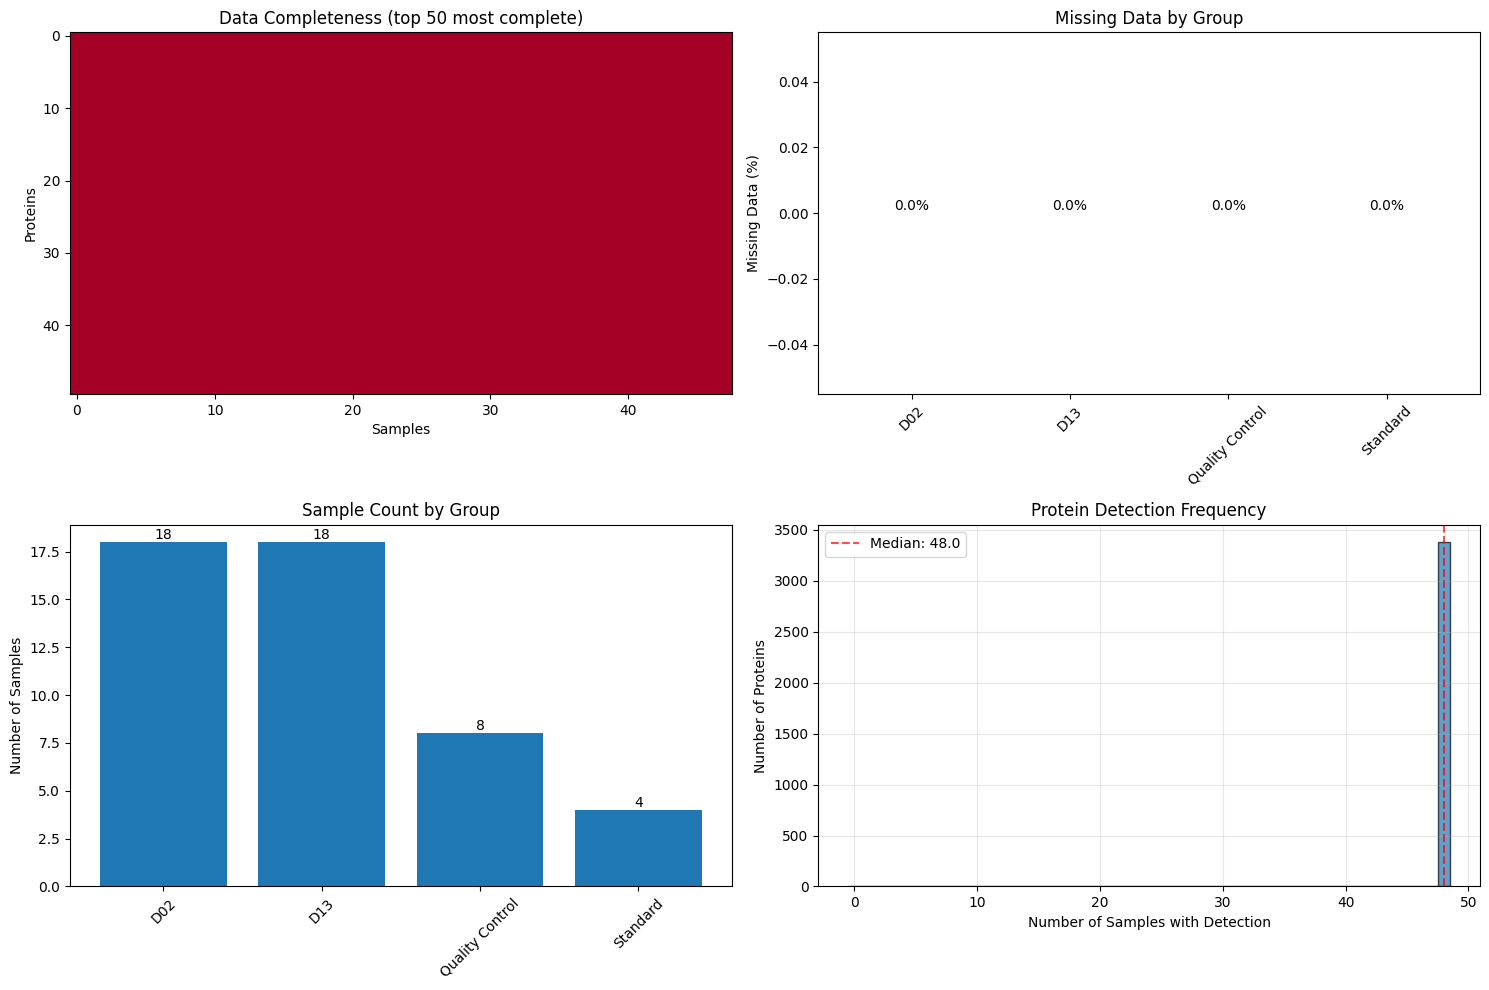


Visualization complete!


In [16]:
# Visualize data completeness
print("=== DATA COMPLETENESS VISUALIZATION ===\n")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Heatmap of missing data pattern (subset if too many proteins)
ax1 = axes[0, 0]
n_proteins_to_show = min(50, len(sample_data))
if len(sample_data) > n_proteins_to_show:
    # Show proteins with most complete data
    top_proteins = protein_completeness.nlargest(n_proteins_to_show).index
    heatmap_data = sample_data.loc[top_proteins]
    title_suffix = f" (top {n_proteins_to_show} most complete)"
else:
    heatmap_data = sample_data
    title_suffix = ""

# Create binary heatmap (1 = data present, 0 = missing)
binary_data = (~heatmap_data.isna()).astype(int)
im = ax1.imshow(binary_data.values, cmap='RdYlBu', aspect='auto')
ax1.set_title(f'Data Completeness{title_suffix}')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Proteins')

# 2. Missing data by group
ax2 = axes[0, 1]
group_missing = {}
for group in group_counts.index:
    group_samples = [s for s in cleaned_sample_names if sample_metadata[s].get('Group') == group]
    if group_samples:
        group_data = sample_data[group_samples]
        missing_pct = group_data.isna().sum().sum() / group_data.size * 100
        group_missing[group] = missing_pct

bars = ax2.bar(group_missing.keys(), group_missing.values())
ax2.set_title('Missing Data by Group')
ax2.set_ylabel('Missing Data (%)')
ax2.tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{height:.1f}%', 
             ha='center', va='bottom')

# 3. Sample count by group
ax3 = axes[1, 0]
bars = ax3.bar(group_counts.index, group_counts.values)
ax3.set_title('Sample Count by Group')
ax3.set_ylabel('Number of Samples')
ax3.tick_params(axis='x', rotation=45)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', 
             ha='center', va='bottom')

# 4. Protein detection frequency
ax4 = axes[1, 1]
detection_counts = sample_data.notna().sum(axis=1)
bins = np.arange(0, len(cleaned_sample_names) + 2) - 0.5
ax4.hist(detection_counts, bins=bins, alpha=0.7, edgecolor='black')
ax4.set_title('Protein Detection Frequency')
ax4.set_xlabel('Number of Samples with Detection')
ax4.set_ylabel('Number of Proteins')
ax4.grid(True, alpha=0.3)

# Add median line
median_detection = detection_counts.median()
ax4.axvline(median_detection, color='red', linestyle='--', alpha=0.7, 
           label=f'Median: {median_detection:.1f}')
ax4.legend()

plt.tight_layout()
plt.show()

print("\nVisualization complete!")

In [17]:
# Final summary
print("=== FINAL SUMMARY ===\n")

print("**Data Overview:**")
print(f"   • Total proteins: {len(processed_data):,}")
print(f"   • Total samples: {len(cleaned_sample_names)}")
print(f"   • Experimental groups: {len(group_counts)}")

print(f"\n**Protein Identifiers:**")
print(f"   • UniProt accessions extracted: {has_accession:,} ({has_accession/total_proteins*100:.1f}%)")
if has_database > 0:
    for db, count in protein_data['UniProt_Database'].value_counts().items():
        if db:  # Skip empty strings
            print(f"   • {db}: {count:,} proteins")

print(f"\n**Sample Information:**")
for group, count in group_counts.items():
    print(f"   • {group}: {count} samples")

print(f"\n**Data Quality:**")
print(f"   • Overall completeness: {completeness:.1f}%")
print(f"   • Complete proteins (all samples): {complete_proteins:,} ({complete_proteins/len(sample_data)*100:.1f}%)")
print(f"   • Majority proteins (>50% samples): {majority_proteins:,} ({majority_proteins/len(sample_data)*100:.1f}%)")

print(f"\n**Available Data:**")
print(f"   • processed_data: Main DataFrame with cleaned sample names")
print(f"   • sample_metadata: Dictionary mapping samples to metadata")
print(f"   • name_mapping: Dictionary mapping original to cleaned names")

print(f"\n**Analysis complete!** Your data is ready for downstream analysis.")

=== FINAL SUMMARY ===

**Data Overview:**
   • Total proteins: 3,378
   • Total samples: 48
   • Experimental groups: 4

**Protein Identifiers:**
   • UniProt accessions extracted: 3,375 (99.9%)
   • SwissProt: 3,283 proteins
   • TrEMBL: 10 proteins

**Sample Information:**
   • D02: 18 samples
   • D13: 18 samples
   • Quality Control: 8 samples
   • Standard: 4 samples

**Data Quality:**
   • Overall completeness: 100.0%
   • Complete proteins (all samples): 3,378 (100.0%)
   • Majority proteins (>50% samples): 3,378 (100.0%)

**Available Data:**
   • processed_data: Main DataFrame with cleaned sample names
   • sample_metadata: Dictionary mapping samples to metadata
   • name_mapping: Dictionary mapping original to cleaned names

**Analysis complete!** Your data is ready for downstream analysis.
